# Part 1 - Converting the VGG face descriptor model to Tensorflow Format

### 1.1 - Importing libraries
First we import all the libaries

In [1]:
import os
import pathlib
import math
import time
import pickle
import numpy as np
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import scipy.io

from tensorflow.keras import datasets, layers, models, initializers
from sklearn.metrics import confusion_matrix
from PIL import Image
from PIL import ImageOps



# Loading in the current working directory 
root_dir = os.getcwd()

### 1.2 - Loading the VGG Face Descriptor Model from .mat files
This portion has code snippets borrowed from this documentation to load in .mat files: https://docs.scipy.org/doc/scipy/reference/generated/scipy.io.loadmat.html

For this portion, we are loading in the VGG Face descriptor weights as well as descriptions as downloaded from the vgg_face_matconvnet.tar.gz file at http://www.robots.ox.ac.uk/~vgg/software/vgg_face/

There are additional parameters in the normalization dictionary such as border, keepAspect, and interpolation parameters that we will not be needing for the future and as such, we omit them here

In [2]:
matlab_weights = scipy.io.loadmat(root_dir + '/vgg_face.mat')

# Open the dictionary containing the data
net = matlab_weights['net']
normalization = net['normalization']
vgg_layers = net['layers']
classes = net['classes']

# Parameters from normalization
image_size = normalization[0][0][0]['imageSize'][0][0]
average_image = normalization[0][0][0]['averageImage'][0]

# Parameters from classes
descriptions = np.array([d[0] for d in classes[0][0][0]['description'][0].flatten()])

### 1.3 - Converting the model into Tensorflow 2
Here we convert the model into Tensorflow 2 using a sequential model as per the paper by Parkhi et al. here https://www.robots.ox.ac.uk/~vgg/publications/2015/Parkhi15/.

We will be adding to the model layer by layer as read from the weights and descriptions above. To do so, we determine what the type of layer is and load in all of the parameters and kernels if needed.

In [3]:
# Initialize model
model = models.Sequential()

# Building the model layer by layer
for ind, layer in enumerate(vgg_layers[0][0][0]):
    
    # Extract layer type and name
    layer_type = layer['type'][0][0][0]
    layer_name = layer['name'][0][0][0]
    
    # If it is a convolution Layer
    if layer_type == "conv":
        stride = layer['stride'][0][0][0][0]
        pad = layer['stride'][0][0][0][0]
        
        # Kernel weights and bias
        W_matrix = initializers.Constant(layer['weights'][0][0][0][0])
        b = initializers.Constant(layer['weights'][0][0][0][1])
        shape = layer['weights'][0][0][0][0].shape
        
        filter_size = shape[0:2]
        num_filt = shape[3]
        
        # As per original paper, fully connected layers
        # have valid padding
        if "fc" in layer_name:
            padding = "valid"
        else:
            padding = "same"
            
        # First layer needs input shape
        if not ind:
            model.add(layers.Conv2D(filters = num_filt, 
                                kernel_size = filter_size, 
                                input_shape = image_size,
                                strides = (stride, stride),
                                padding = padding,
                                activation = "relu",
                                kernel_initializer = W_matrix,
                                bias_initializer = b))

        else:
            model.add(layers.Conv2D(filters = num_filt, 
                                kernel_size = filter_size,
                                strides = (stride, stride),
                                padding = padding,
                                activation = "relu",
                                kernel_initializer = W_matrix,
                                bias_initializer = b))
    # Max pool layer with stride 2 and pool size 2
    elif layer_type == "pool":
        model.add(layers.MaxPooling2D(pool_size = (2, 2), strides = (2, 2), padding='same'))
    # Dropout layer with 50% rate
    elif layer_type == "dropout":
        model.add(layers.Dropout(0.5))
    # Final softmax output
    elif layer_type == "softmax":
        model.add(layers.Flatten())
        model.add(layers.Softmax())

Now we compile and build the model along with a summary of the overall model

In [4]:
# Compile and build the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.build(input_shape = image_size)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 64)      1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 224, 224, 64)      36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 112, 112, 128)     147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 56, 56, 256)       2

### 1.4 - Testing a sample image
We will feed in one sample image of Aamir Khan from the vgg_face_matconvnet.tar.gz file and see if it outputs with high confidence the correct person

Sample image


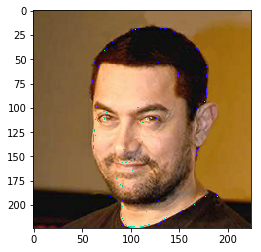

In [5]:
# Operations: - cropping so that image is centered
#             - scaling to 224 x 224 x 3
#             - bicubic interpolation
#             - subtracting average image
# 
# Interpolation comes from normalization[0][0][0]['interpolation'][0][0]

img = tf.io.read_file(root_dir + "/ak.jpg")
img = tf.image.decode_jpeg(img, channels=3)
img = tf.image.crop_to_bounding_box(img, 0, 0, 250, 250)
img = tf.image.resize(img, [image_size[0], image_size[0]], method=tf.image.ResizeMethod.BICUBIC)
plt.imshow(img.numpy().astype(np.uint8))
print("Sample image")

In [6]:
# For input into the model
img = np.array([img.numpy()])

# Inferencing
res = model.predict(img).flatten()

# Top 5 results from model
k = 5
ranking = res.argsort()[-k:][::-1]
for rank in ranking:
    print("Name: %s, Probability: %.2f%%" % (descriptions[rank], res[rank] * 100))

Name: Aamir_Khan, Probability: 77.32%
Name: Adam_Driver, Probability: 20.19%
Name: Manish_Dayal, Probability: 0.55%
Name: D.B._Woodside, Probability: 0.22%
Name: John_Abraham, Probability: 0.13%


Looks like the model is working well!

# Part 2 - Creating a gender classifier with VGG Face Descriptor net
For this portion we will now transfer the learning done on the previous model to build a classifier for gender.

### 2.1 - Initializing the dataset along with initializing batch size parameters
Determining constants for training here

In [7]:
gender_dir = pathlib.Path(root_dir + "/combined")

# Size of the dataset to train on
num_of_images = len([item for item in tf.data.Dataset.list_files(str(gender_dir/"*/*/*"))])

# Batch size for training along with the minimum number of steps needed to cover whole dataset 
batchSize = 256
steps = math.ceil(num_of_images/batchSize)

 We avoid the preprocessing module for loading in data because of compatibility problems with tensorflow v2.1+ and instead use `tf.data.Dataset` for containing our data

In [8]:
# Lambda function for loading in the image into tensors
def getImage(x, l):
    label = 0 if l == "M" else 1
    img = tf.io.read_file(x)
    img = tf.image.decode_jpeg(img, channels=3) #color images
    img = tf.image.resize(img, [image_size[0], image_size[0]], method=tf.image.ResizeMethod.BICUBIC)
    return img, label

# Male faces dataset
male_files = tf.data.Dataset.list_files(str(gender_dir/"*/*_M/*"))
male = male_files.map(lambda x: getImage(x, "M"))

# Female faces dataset
female_files = tf.data.Dataset.list_files(str(gender_dir/"*/*_F/*"))
female = female_files.map(lambda x: getImage(x, "F"))

# Concatenate the datasets and interleave them
dataset = tf.data.Dataset.zip((male, female)).flat_map(
    lambda x, y: male.from_tensors(x).concatenate(female.from_tensors(y)))

Shuffle (with a buffer size of 1000) and create a `tf.data.Dataset` iterator with batchsize of 256 and a prefetching buffer size of 1000

In [9]:
dataset = dataset.shuffle(1000)
dataset = dataset.batch(batchSize)
dataset = dataset.prefetch(1000)

### 2.2 - Loading in the data and inferencing to get feature descriptors for the classifier
Loading in the data from the iterator along with creating the train, validation and test splits. Here we use an approximate 75%, 12.5%, 12.5% split in our training, validation and test sets. 

**NOTE: This takes a couple of minutes to load all of the data**

In [10]:
# Load in the data
data = []
labels = []
for i in range(steps):
    if i % 10 == 0:
        print("Loaded %d batches" % (i))
    batch, l = next(iter(dataset))
    data.append(batch)
    labels.append(l)

# Slice into train, val, and test sets
data_n = len(data)
train = data[:round(0.75 * data_n)]
val = data[round(0.75 * data_n) : round(0.875 * data_n)]
test = data[round(0.875 * data_n):]

train_labels = labels[:round(0.75 * data_n)]
val_labels = labels[round(0.75 * data_n) : round(0.875 * data_n)]
test_labels = labels[round(0.875 * data_n):]

Loaded 0 batches
Loaded 10 batches
Loaded 20 batches
Loaded 30 batches
Loaded 40 batches
Loaded 50 batches
Loaded 60 batches
Loaded 70 batches
Loaded 80 batches
Loaded 90 batches
Loaded 100 batches
Loaded 110 batches
Loaded 120 batches


Now that we have all train, validation and test sets, we inference all of the data to get the outputs of the VGG face descriptor model above. The input is a `224 x 224 x 3` image and the output is a `1 x 2622` output which is an array of probabilities of which face the input image detected. We store the results of the inferencing into lists of the batched tensors called `feature_train`, `feature_val` and `feature_test`.

**NOTE: This operation takes approximately 40 minutes on a CPU with no GPU. We note that with a GPU implementation or an inference optimizer, this can be reduced to be much quicker with the use of tensorflow-gpu or TensorRT packages from Nvidia. But for the scope of this project, we will omit this implementation**

In [11]:
feature_train = []
for i, batch in enumerate(train):
    if i % 10 == 0:
        print("Inferenced %d batches" % (i))
    feature_train.append(model.predict(batch.numpy()))
    
feature_val = []
for i, batch in enumerate(val):
    if i % 10 == 0:
        print("Inferenced %d batches" % (i))
    feature_val.append(model.predict(batch.numpy()))
    
feature_test = []
for i, batch in enumerate(test):
    if i % 10 == 0:
        print("Inferenced %d batches" % (i))
    feature_test.append(model.predict(batch.numpy()))
    
# OPTIONAL: Pickling for fast loading and unloading of inferenced
#           data to read.
#
# WRITING:
# with open('train.pickle', 'wb') as b:
#     pickle.dump(feature_train,b)
# with open('val.pickle', 'wb') as b:
#     pickle.dump(feature_val,b)
# with open('test.pickle', 'wb') as b:
#     pickle.dump(feature_test,b)
#
# READING
# with open('train.pickle', 'rb') as b:
#     feature_train = pickle.load(b)
# with open('val.pickle', 'rb') as b:
#     feature_val = pickle.load(b)
# with open('test.pickle', 'rb') as b:
#     feature_test = pickle.load(b)

Inferenced 0 batches
Inferenced 10 batches
Inferenced 20 batches
Inferenced 30 batches
Inferenced 40 batches
Inferenced 50 batches
Inferenced 60 batches
Inferenced 70 batches
Inferenced 80 batches
Inferenced 90 batches
Inferenced 0 batches
Inferenced 10 batches
Inferenced 0 batches
Inferenced 10 batches


The next lines are to collate the batches in the validation and test sets

In [12]:
# Collating validation set into one tensor of size
# (BATCHSIZE * STEPS * 0.125) x 2622
v = feature_val[0]
for i in range(1, len(feature_val)):
    v = np.vstack((v, feature_val[i]))
feature_val = v
val_labels = np.array([d for d in val_labels]).flatten()

# Collating test set into one tensor of size
# (BATCHSIZE * STEPS * 0.125) x 2622
t = feature_test[0]
for i in range(1, len(feature_test)):
    t = np.vstack((t, feature_test[i]))
feature_test = t
test_labels = np.array([d for d in test_labels]).flatten()

Checking the shapes of our train, val, test sets

In [13]:
print("Number of training batches: ", len(feature_train))
print("Each training batch tensor shape: ", feature_train[0].shape)

print("Validation set shape: ", feature_val.shape)
print("Test set shape: ", feature_test.shape)

Number of training batches:  98
Each training batch tensor shape:  (256, 2622)
Validation set shape:  (4096, 2622)
Test set shape:  (4096, 2622)


### 2.3 - Creating the classifier
We use a simple neural network with 2 fully-connected layers with 16 units and a ReLU activation function that acts as additional dense layers to the VGG Face Detection model. Then we feed this into a Dropout layer with 40% rate. Then the output of the model is a single-layer sigmoid output trained on Binary Cross-entropy loss. We use an Adam optimizer for weight training

In [14]:
gender_model = models.Sequential()

gender_model.add(layers.Dense(16, activation = "relu"))
gender_model.add(layers.Dense(16, activation = "relu"))
gender_model.add(layers.Dropout(0.4))
gender_model.add(layers.Dense(1, activation = "sigmoid"))

gender_model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

Include early stopping params

In [15]:
# Initializing variables for saving training results
loss, accuracy, val_accuracy, val_loss = [], [], [], []

# Variables for early stopping. 
# Tolerance is based on loss and the patience is for 2 epochs.
tolerance = 1e-2
patience = 2
stop_count = 0
prev_loss = None

Manually loop through epochs since we have batched data. Create checkpoints where needed

In [16]:
# Checkpoint directory
if not os.path.exists(root_dir + "/checkpoints"):
    os.makedirs(root_dir + "/checkpoints")

# TRAINING LOOPS
for epoch in range(50):
    print(("Epoch: ", epoch))
    val_loss_sum = 0
    
    # Train using the batches and store losses and accuracy
    for i, batch in enumerate(feature_train):
        if i % 40 == 0:
            print("Batch Number:, ", i)
        
        history = gender_model.fit(batch, 
                                   train_labels[i], 
                                   verbose = 0, 
                                   validation_data = (feature_val, val_labels))
        loss.append(history.history['loss'])
        accuracy.append(history.history['accuracy'])
        val_accuracy.append(history.history['val_accuracy'])
        val_loss.append(history.history['val_loss'])
        
        val_loss_sum += history.history['val_loss'][0]
        
        
    avg_val_loss = val_loss_sum / len(feature_train)
    print(avg_val_loss)
    
    #Checkpointing
    gender_model.save_weights('./checkpoints/ck-epoch%d' % (epoch))
    
    # Early stopping if the validation loss does not improve after
    # patience amount of epochs
    if stop_count == patience:
        break
        
    if not prev_loss:
        prev_loss = avg_val_loss
    elif prev_loss >= avg_val_loss:
        prev_loss = avg_val_loss
        stop_count = 0
    else:
        stop_count += 1
        

('Epoch: ', 0)
Batch Number:,  0
Batch Number:,  40
Batch Number:,  80
0.5866136404932761
('Epoch: ', 1)
Batch Number:,  0
Batch Number:,  40
Batch Number:,  80
0.5382249185017177
('Epoch: ', 2)
Batch Number:,  0
Batch Number:,  40
Batch Number:,  80
0.5364206871207879
('Epoch: ', 3)
Batch Number:,  0
Batch Number:,  40
Batch Number:,  80
0.5356779177578128
('Epoch: ', 4)
Batch Number:,  0
Batch Number:,  40
Batch Number:,  80
0.5348459682902511
('Epoch: ', 5)
Batch Number:,  0
Batch Number:,  40
Batch Number:,  80
0.5343776278349818
('Epoch: ', 6)
Batch Number:,  0
Batch Number:,  40
Batch Number:,  80
0.5342452118591386
('Epoch: ', 7)
Batch Number:,  0
Batch Number:,  40
Batch Number:,  80
0.5339278457116108
('Epoch: ', 8)
Batch Number:,  0
Batch Number:,  40
Batch Number:,  80
0.5342387903709801
('Epoch: ', 9)
Batch Number:,  0
Batch Number:,  40
Batch Number:,  80
0.5337167905301464
('Epoch: ', 10)
Batch Number:,  0
Batch Number:,  40
Batch Number:,  80
0.5340332802461119
('Epoch: 

### 2.4 - Model summary and architecture
We see the results from the 2 FC-layers and the single sigmoid layer along with the architecture

In [17]:
gender_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (32, 16)                  41968     
_________________________________________________________________
dense_1 (Dense)              (32, 16)                  272       
_________________________________________________________________
dropout_2 (Dropout)          (32, 16)                  0         
_________________________________________________________________
dense_2 (Dense)              (32, 1)                   17        
Total params: 42,257
Trainable params: 42,257
Non-trainable params: 0
_________________________________________________________________


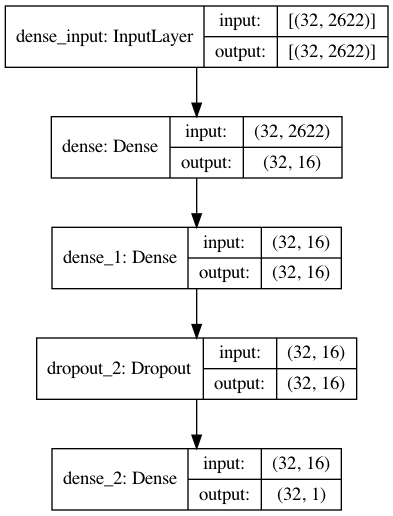

In [18]:
tf.keras.utils.plot_model(gender_model, to_file="architecture.png", show_shapes=True)

### 2.5 - Plotting and results
We show the training and validation accuracy/loss over time as we train the model. Note that while the model plateaus quickly, the validation loss continues to decrease for 14 epochs

Accuracy and loss over time for train/val sets


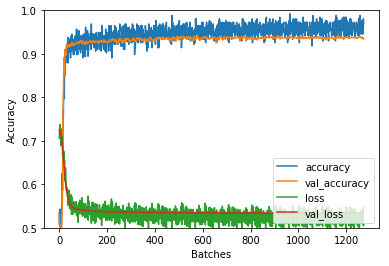

In [19]:
plt.figure()
plt.plot(accuracy, label='accuracy')
plt.plot(val_accuracy, label='val_accuracy')
plt.plot(loss, label='loss')
plt.plot(val_loss, label='val_loss')
plt.xlabel('Batches')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')
print("Accuracy and loss over time for train/val sets")

Showing the results from evaluation for the first 30 examples in the test set

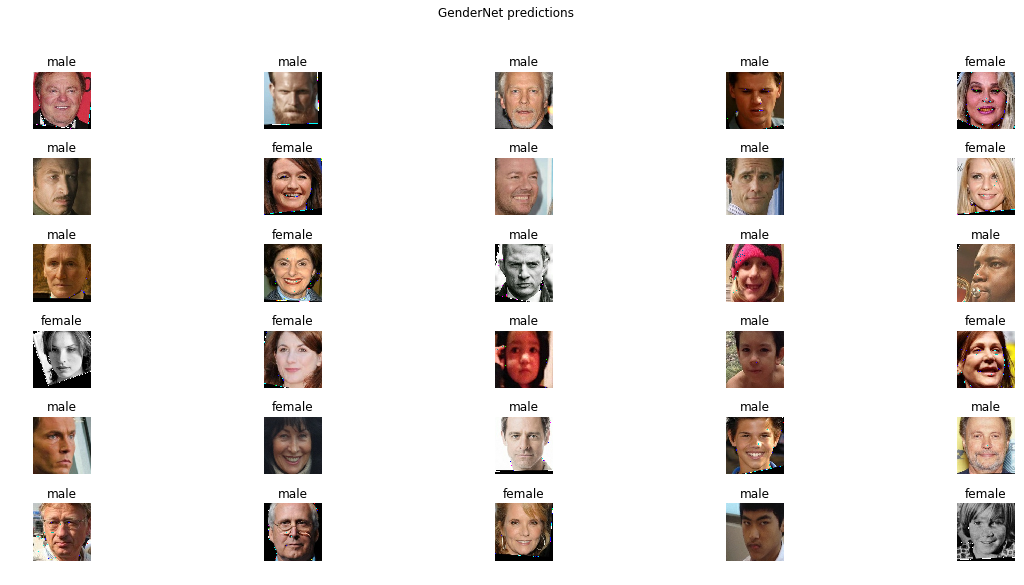

In [20]:
pred = [1 if l > 0.5 else 0 for l in gender_model.predict(feature_test)]
plt.figure(figsize=(20,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
    plt.subplot(6,5,n+1)
    plt.imshow(test[0].numpy().astype(np.uint8)[n])
    if pred[n] == 0:
        label = "male"
    else:
        label = "female"
    plt.title(label)
    plt.axis('off')
    _ = plt.suptitle("GenderNet predictions")

Here, we show the accuracy and loss on the held out test set. We see that we achieve an accuracy of around 94% with without having to train a large neural network!

In [21]:
test_loss, test_acc = gender_model.evaluate(feature_test, test_labels, verbose=2)

128/128 - 0s - loss: 0.5250 - accuracy: 0.9436


In [22]:
print("Validation Error: %.2f%%" % ((1 - val_accuracy[-1][0]) * 100))
print("Train Error: %.2f%%" % ((1 - accuracy[-1][0]) * 100))
print("Test Error: %.2f%%" % ((1 - test_acc) * 100))

Validation Error: 6.49%
Train Error: 3.12%
Test Error: 5.64%


Computing F1-Score to assess model fit

In [23]:
tn, fp, fn, tp = confusion_matrix(pred, test_labels).ravel()
print("F1 Score: %.4f" % (tp / (tp + 0.5 * (fp + fn))))
print("Accuracy: %.2f%%" % ((tp + tn)/(tn + fp + fn + tp) * 100))

F1 Score: 0.9441
Accuracy: 94.36%
